**LSTM**

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load the dataset
url = 'https://raw.githubusercontent.com/DZStem/ADAML_Workshop5/main/Stock/AAPL.csv'
df1 = pd.read_csv(url)
df1 = df1.set_index('date')
df1 = df1.iloc[3:]

# Drop unnecessary columns and extract data
data = df1.drop(['Unnamed: 0', 'symbol'], axis=1).values

In [69]:
# Normalize the data (apply MinMaxScaler across all features)
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Define sequence length
sequence_length = 100

# Prepare input (X) and output (Y) sequences
X, Y = [], []
for i in range(len(data_normalized) - sequence_length):
    X.append(data_normalized[i:i + sequence_length])  # Input: sequence_length x num_features
    Y.append(data_normalized[i + sequence_length])    # Output: num_features

X = np.array(X)  # Shape: (samples, sequence_length, num_features)
Y = np.array(Y)  # Shape: (samples, num_features)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0181
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0027
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0025
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0021
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0024
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0019
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0023
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0026
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0021
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0019
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0024
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0022
Epoch 13/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0021
Epoch 14/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0019
Epoch 15/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0022
Epoch 16/20
47/

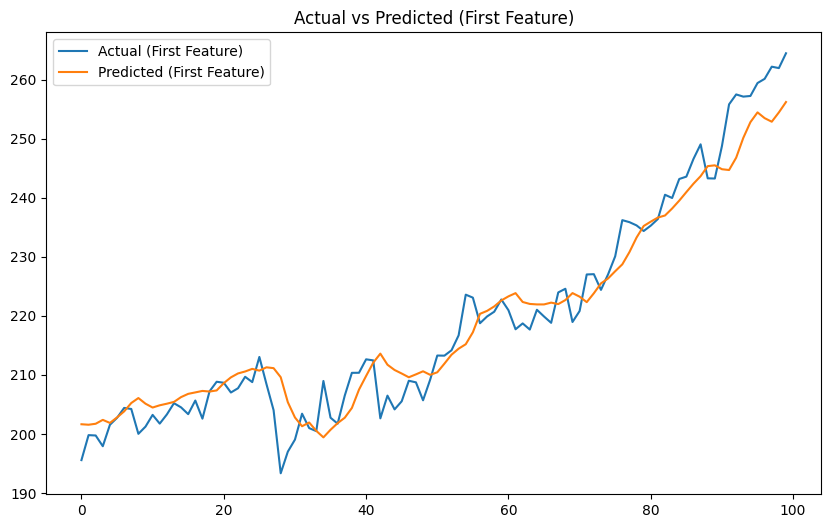

In [70]:
# Build the LSTM model for multivariate input/output
model = Sequential([
    LSTM(units=80, input_shape=(sequence_length, X.shape[2])),  # Sequence length and features
    Dense(units=Y.shape[1])  # Number of output features
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, epochs=20, batch_size=20, verbose=1)

# Predict on the test set
predictions = model.predict(X_test)

# Inverse scale predictions and actual values for evaluation
predictions_rescaled = scaler.inverse_transform(predictions)
Y_test_rescaled = scaler.inverse_transform(Y_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(Y_test_rescaled, predictions_rescaled)
print(f"Mean Squared Error: {mse}")

# Optional: Visualize some predictions vs actuals
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(Y_test_rescaled[:100, 0], label='Actual (First Feature)')
plt.plot(predictions_rescaled[:100, 0], label='Predicted (First Feature)')
plt.legend()
plt.title("Actual vs Predicted (First Feature)")
plt.show()

**Forecasting**

In [71]:
# Initialize prediction_X with the last sequence from the dataset
prediction_X = X[0]  # Ensure this is a sequence of shape (sequence_length, num_features)

# Number of steps to forecast
steps = 100

# Store forecasts
forecasts = []

for i in range(steps):
    # Reshape prediction_X to include batch dimension
    prediction_X_batch = prediction_X.reshape((1, prediction_X.shape[0], prediction_X.shape[1]))

    # Predict the next step
    forecast_new = model.predict(prediction_X_batch)

    # Add the prediction to forecasts
    forecasts.append(forecast_new[0])  # Remove batch dimension from prediction

    # Update prediction_X: Remove the first value and append the new prediction
    prediction_X = np.vstack([prediction_X[1:], forecast_new])

# Convert forecasts to a NumPy array for further processing
forecasts = np.array(forecasts)

# Inverse transform the forecasts if needed (to return to original scale)
forecasts_rescaled = scaler.inverse_transform(forecasts)
print("Forecasts (original scale):")
print(forecasts_rescaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

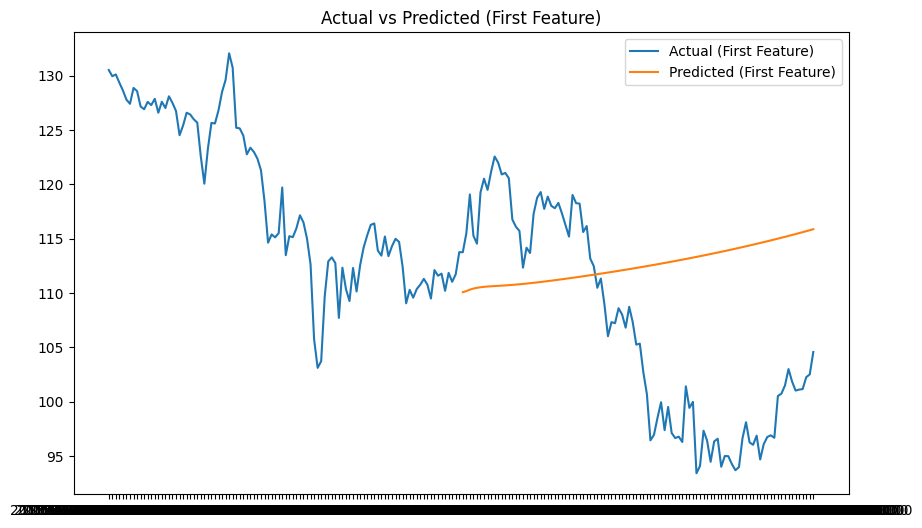

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(df1.index[:200],data[:200, 0], label='Actual (First Feature)')
plt.plot(df1.index[100:200],forecasts_rescaled[:,0], label='Predicted (First Feature)')
plt.legend()
plt.title("Actual vs Predicted (First Feature)")
plt.show()